In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #To handle large images
import random
from scipy import ndimage
from PIL import Image

from transformers import SamModel, SamConfig, SamProcessor
import torch

print(os.getcwd())

/home/piyushsamant/Data/UnitoChest/SAM Experiment/SAM without_patches


In [14]:
large_test_images = tifffile.imread('../../2 Extracted Data/Test/stack_test_image.tiff')

# large_test_masks = tifffile.imread('../../2 Extracted Data/Test/stack_test_GT.tiff')

print(large_test_images.shape)

# Resize function
def resize_image(image, size=(256, 256)):
    image_pil = Image.fromarray(image)
    return np.array(image_pil.resize(size, Image.NEAREST))


# # Resize all images and masks
resized_images = np.array([resize_image(img) for img in large_test_images])
# resized_masks = np.array([resize_image(mask) for mask in large_masks])

print("Resized shape of images:", resized_images.shape)
# print("Resized shape of masks:", resized_masks.shape)

(2467, 512, 512)
Resized shape of images: (2467, 256, 256)


In [16]:
# Load the model configuration
model_config = SamConfig.from_pretrained('facebook/sam-vit-base')
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load('SAM 256 X 256.pth'))
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

/home/piyushsamant/tensorflow_venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [17]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [18]:
# Define the size of your array
array_size = 256
# Define the size of your grid
grid_size = 10
# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)
# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)
# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()
# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

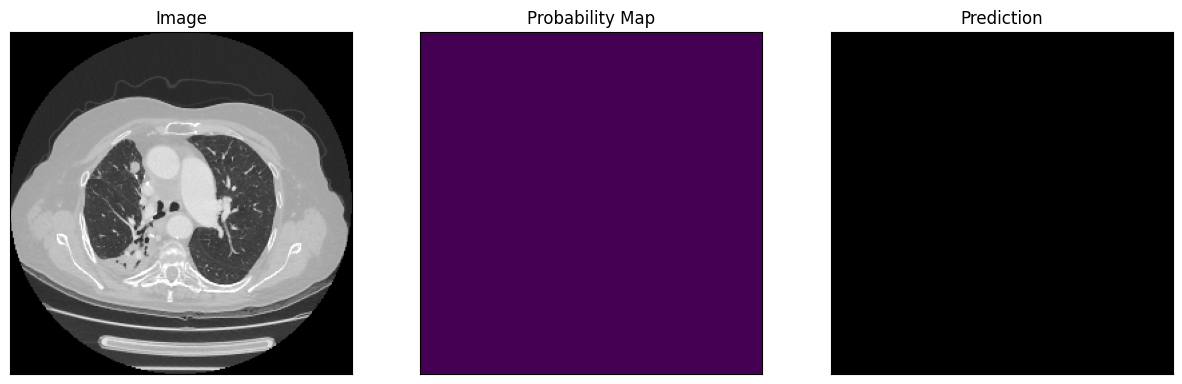

In [28]:
single_test_image = resized_images[1090]

def convert_grayscale_to_rgb(image):
    # Ensure the image is a NumPy array
    if not isinstance(image, np.ndarray):
        raise ValueError("Image must be a NumPy array")
    
    # Stack the grayscale image along the last axis to create an RGB image
    return Image.fromarray(np.stack([image] * 3, axis=-1))

# single_patch = Image.fromarray(random_array)
single_test_image_1 = convert_grayscale_to_rgb(single_test_image)

inputs = processor(single_test_image_1, input_points=input_points, return_tensors="pt")
# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()
# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_test_image_1), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
